In [1]:
from gensim.models import FastText
import os,sys
from urllib.parse import urlparse
from getImagesFunctions import *
from getDataFunctionsClasses import *
from gensim.models import Word2Vec
import gensim
import random
import langid
import re
import ast
import concurrent
import htmldate
import time
import uuid
from nltk.tokenize import word_tokenize
import multiprocessing
from multiprocessing import Process, Manager, Pool
import sys
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from scipy import spatial

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
list_urls = []

for i in range(1,6):

    if i == 1:
        print('Iteration {}'.format(i))
        temp = Organize.gatherPagesUrlsFolder("image_npg_",i)
        print("{} urls, {} unique ones".format(len(temp),len(set(temp))))
        current = list(set(temp))
        print('Iteration {}:{} urls downloaded'.format(i,len(list(set(temp)))))
        list_urls = list_urls + current

    if i > 1:
        print('Iteration {}'.format(i))
        temp = Organize.gatherPagesUrlsFolder("image_npg_",i)
        print("{} urls, {} unique ones".format(len(temp),len(set(temp))))
        len_unique_new = len([u for u in temp if u not in current])
        perc_new = round(len_unique_new / len(temp) * 100)
        print('Iteration {}: {} urls downloaded. {} new ones. That is {}% new'.format(i,len(list(set(temp))), len([u for u in list(set(temp)) if u not in current]), perc_new))
        current = list(set(temp))
        list_urls = list_urls + current
    

Iteration 1
Finished page url gathering: 0 .json file errors
256 urls, 256 unique ones
Iteration 1:256 urls downloaded
Iteration 2
Finished page url gathering: 3 .json file errors
44858 urls, 2653 unique ones
Iteration 2: 2653 urls downloaded. 2398 new ones. That is 59% new
Iteration 3
Finished page url gathering: 5 .json file errors
385837 urls, 9034 unique ones
Iteration 3: 9034 urls downloaded. 6422 new ones. That is 19% new
Iteration 4
Finished page url gathering: 8 .json file errors
894992 urls, 18229 unique ones
Iteration 4: 18229 urls downloaded. 9496 new ones. That is 9% new
Iteration 5
Finished page url gathering: 64 .json file errors
1310964 urls, 37380 unique ones
Iteration 5: 37380 urls downloaded. 20450 new ones. That is 7% new


In [4]:
print(len(list_urls), "urls found")
print(len(set(list_urls)), "urls found after duplicate removal")
list_urls = list(set(list_urls))

38857 urls found
38857 urls found after duplicate removal


In [5]:
# Find dates in parsed URLs

parsed = [urlparse(i) for i in list_urls]
keyz = "scheme tld path params query fragment".split(' ')
parsed_ = dict()
for u in parsed:
    parsed_.update({u:{keyz[c]:i for c,i in enumerate(u)}})

In [7]:
parsed[0:100]

[ParseResult(scheme='http', netloc='www.entretemps.asso.fr', path='/Nicolas/2008/68.htm', params='', query='', fragment=''),
 ParseResult(scheme='https', netloc='yuki.la', path='/int/107320306', params='', query='', fragment=''),
 ParseResult(scheme='https', netloc='docs.microsoft.com', path='/en-us/office/dev/scripts/overview/excel', params='', query='', fragment=''),
 ParseResult(scheme='https', netloc='www.kaskus.co.id', path='/thread/57d90e439252334c058b456c/15-foto-bersejarah-dunia/2', params='', query='', fragment=''),
 ParseResult(scheme='http', netloc='www.cookntrip.com', path='/voyages/arrivee-fracassante-ho-chi-minh', params='', query='', fragment=''),
 ParseResult(scheme='http', netloc='pensive97.rssing.com', path='/chan-25070368/all_p2.html', params='', query='', fragment=''),
 ParseResult(scheme='https', netloc='unstoppablesun.com', path='/2016/04/13/descendants-of-the-sun-ep-15-recap/', params='', query='', fragment=''),
 ParseResult(scheme='https', netloc='www.taringa.ne

In [127]:
urlsp = [[x for x in urlparse(i) if i][2:] for i in list_urls]
urlsp = [[x for x in i if x] for i in urlsp]
urlsp = [" ".join(x) for x in urlsp]

In [128]:
delimiters = "/", ".", " "
regexPattern = '|'.join(map(re.escape, delimiters))

In [129]:
sentences = []
suitable = 0
unsuitable = 0
for u in urlsp:
    u = re.split(regexPattern, u)
    u = [x for x in u if x]
    if len(u) == 0:
        unsuitable += 1
        continue
    maxu = max(u, key=len)
    if "-" in maxu:
        maxu = maxu.split('-')
        maxu = [m for m in maxu if m and len(m) < 20]
        
        if len(maxu) > 1:
            sentences.append(maxu)
            suitable += 1
        else:
            unsuitable += 1
    else:
        unsuitable += 1
        
print("found {} suitable and {} unsuitable links. {}% of the links are suitable".format(suitable, unsuitable, round(suitable/len(urlsp)*100)))


found 24070 suitable and 14787 unsuitable links. 62% of the links are suitable


In [130]:
sentences = [i for i in sentences if langid.classify(" ".join(i))[0] == 'en']

In [131]:
sentences

[['jeff', 'teagues', 'career', 'in', 'atlanta'],
 ['10', 'photographs', 'stopped', 'world'],
 ['full', 'kiwi', 'leather', 'restoration', 'by', 'bespoke', 'leathering'],
 ['the', 'official', 'air', 'suspension', 'thread'],
 ['ICE',
  'is',
  'rushing',
  'to',
  'delete',
  'years',
  'of',
  'data',
  'on',
  'detainee',
  'deaths',
  'sexual',
  'assaults',
  'because',
  'theres',
  'nothing',
  'to',
  'see',
  'here',
  'Move',
  'along',
  'citizen'],
 ['sps', 'lps', 'hard', 'corals', '101', 'with', 'pictures'],
 ['tunnel',
  'ice',
  'anyone',
  'ever',
  'figure',
  'out',
  'a',
  'way',
  'to',
  'stop',
  'it'],
 ['old',
  'school',
  'autotek',
  'mean',
  'machine',
  'hc',
  '225mxi',
  'need',
  'to',
  'sell'],
 ['facebook',
  'allows',
  'postings',
  'napalm',
  'girl',
  'photo',
  'after',
  'debate',
  '012123'],
 ['building',
  'a',
  'halo',
  'm6c',
  'a',
  'how',
  'to',
  'in',
  '1347',
  'simples',
  'steps'],
 ['nhiep',
  'anh',
  'gia',
  'em',
  'be',
  '

In [48]:
documents = [TaggedDocument(doc, [c]) for c, doc in enumerate(sentences)]
d2v_model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [49]:
for i in range(0,10):
    print("URL: ", " ".join(documents[i][0]))
    sen_num = i

    for s,sim in d2v_model.docvecs.most_similar(positive=[d2v_model.infer_vector(sentences[sen_num])],topn=5):
        print(" ".join(documents[s][0]))
    print('--------')

URL:  jeff teagues career in atlanta


C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


em be napalm phan thi kim phuc duoc trao giai thuong dresden tai duc 83254
vietnam then and now
storia foto bambina vietnam napalm
yeti the himalayan kitchen 50 a 2nd floor hauz khas village hauz khas new delhi
KIM PHUC SIGNED AUTOGRAPHED PULITZER PRZE WINNING VIETNAM WAR PHOTO WEXACT PROOF Vietnam 196175 402003
--------
URL:  10 photographs stopped world
mad lust envys headphone gaming guide 2 2 2020 drop thx panda review added
giss a temperature outlier again this time for the southern hemisphere
todays chat no set topic
small microwaves
1983 national sport wheels bmx
--------
URL:  full kiwi leather restoration by bespoke leathering
action viewnews itemid 471052
Transforming war peace Artist turns devastating historic photos children ravaged violent conflict famine happy illustrations
72778 premier auto detailing evan 2009 bmw 335i polished opti coated
facebook censura foto nuda kim phuc
ghosting background color of fixed div when scrolling in chrome
--------
URL:  the official air 

In [20]:
documents[]

1

## KMEANS

In [38]:
#d2v_model = Doc2Vec(documents, size = 100, window = 10, min_count = 2, workers=7, dm = 1,alpha=0.025, min_alpha=0.001)
#d2v_model.train(documents, total_examples=d2v_model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

In [51]:
kmeans_model = KMeans(n_clusters=10, init='k-means++', max_iter=100) 
X = kmeans_model.fit(d2v_model.docvecs.doctag_syn0)
labels=kmeans_model.labels_.tolist()

In [64]:
df = pd.DataFrame(d2v_model.docvecs.doctag_syn0)
df['ids'] = ids
df['labels'] = ids

ValueError: Length of values does not match length of index

In [52]:
l = kmeans_model.fit_predict(d2v_model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(d2v_model.docvecs.doctag_syn0)
datapoint = pca.transform(d2v_model.docvecs.doctag_syn0)

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

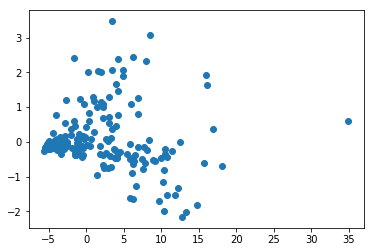

In [55]:
plt.figure
#label1 = ['#FFFF00', '#008000', '#0000FF', '#800080']
#color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1]) #, c=color

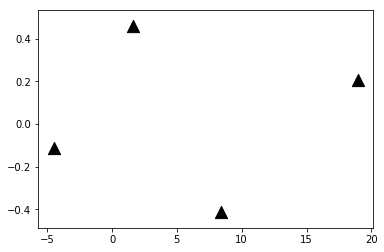

In [46]:
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [47]:
labels

[2,
 2,
 0,
 0,
 3,
 3,
 0,
 2,
 0,
 3,
 3,
 0,
 3,
 0,
 0,
 1,
 0,
 0,
 0,
 3,
 3,
 0,
 0,
 0,
 3,
 3,
 1,
 0,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 0,
 3,
 3,
 3,
 0,
 0,
 1,
 0,
 1,
 3,
 3,
 0,
 3,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 3,
 0,
 3,
 1,
 0,
 1,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 1,
 1,
 1,
 0,
 3,
 0,
 3,
 1,
 3,
 3,
 0,
 0,
 0,
 3,
 1,
 3,
 0,
 1,
 0,
 0,
 0,
 1,
 3,
 1,
 1,
 2,
 0,
 1,
 0,
 3,
 0,
 1,
 0,
 3,
 3,
 3,
 0,
 3,
 0,
 0,
 3,
 0,
 3,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 1,
 3,
 0,
 3,
 0,
 1,
 0,
 0,
 3,
 0,
 0,
 1,
 1,
 3,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 3,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 1,
 0,
 0,
 2,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 3,
 0,
 0,
 0,
 3,
 0,
 0,
 2,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 3,
 1,
 3,
 3,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 3,
 0,
 0,
 1,
 0,
 3,
 3,
 1,
 3,
 0,
 1,
 0,
 0,
 0,
 3,
 0,
 0,
 1,
 1,
 3,
 0,
 1,
 1,
 0,
 2,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 3,
 0,
 1,
 0,
 0,
 3,


In [134]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline

In [141]:
words = [item for sublist in sentences for item in sublist if len(item) > 3]
stopwords = set(STOPWORDS)

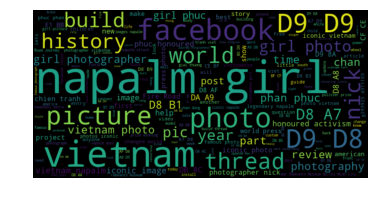

In [142]:
wordcloud = WordCloud(stopwords = stopwords,width=800, height=400).generate(" ".join(words))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wc.png', dpi=400)

plt.show()